## Data Preparation 

In [1]:
# Import Block
import os
import time
import random
import numpy as np
import pandas as pd

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import patches
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity


# Dataset Directories
data_dir = "D:\\Trade-Off_CBIR\\dataset\\Corel-1K"
data_dir_GHIM = "D:\\Trade-Off_CBIR\\dataset\\GHIM-10K"

print("Classes available (Corel-1K):", os.listdir(data_dir))
print("Classes available (GHIM-10K):", os.listdir(data_dir_GHIM))


# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Classes available (Corel-1K): ['africans', 'beaches', 'buildings', 'buses', 'dinosaurs', 'elephants', 'flowers', 'food', 'horses', 'mountains']
Classes available (GHIM-10K): ['aircraft', 'buildings', 'butterfly', 'cars', 'dragon fly', 'fireworks', 'flowers', 'hen', 'horses', 'insects', 'motorcycles', 'mountains', 'sea shores', 'ships', 'sunset', 'temples', 'trees', 'valleys', 'walls', 'yacht']
Using device: cuda


## Dataset: Corel-1K

### Tahap 1: Model Initialization

In [2]:
# ======================================================
# Tahap 1: Model Initialization (Classical Context Encoders)
# ======================================================
import cv2
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.preprocessing import normalize

# -----------------------------
# Utility preprocessing
# -----------------------------
def preprocess(img, target_size=(128, 128)):
    """
    Resize + CLAHE preprocessing
    """
    img = cv2.resize(np.array(img), target_size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    return gray

# -----------------------------
# Classical feature extractors
# -----------------------------
def extract_hog(img):
    # img sudah grayscale & preprocessed
    return hog(
        img,
        orientations=12,         # lebih banyak orientasi
        pixels_per_cell=(16,16), # lebih besar untuk global info
        cells_per_block=(2,2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )

def extract_glcm(img):
    glcm = graycomatrix(
        img,
        distances=[1,2,3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=32,
        symmetric=True,
        normed=True
    )
    props = ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]
    feat = []
    for p in props:
        feat.extend(graycoprops(glcm, p).flatten())
    return np.array(feat)

def extract_gist(img):
    feats = []
    ksize = 31
    # lebih banyak orientasi
    thetas = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6]
    for theta in thetas:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma=4.0,
                                    theta=theta, lambd=10.0,
                                    gamma=0.5, psi=0)
        fimg = cv2.filter2D(img, cv2.CV_32F, kernel)
        feats.append(fimg.mean())
        feats.append(fimg.var())
    return np.array(feats)

# -----------------------------
# Context & Target Encoders
# -----------------------------
class ContextEncoder:
    def __init__(self, method):
        self.method = method.lower()

    def forward(self, img):
        gray = preprocess(img)
        if self.method == "hog":
            return extract_hog(gray)
        elif self.method == "glcm":
            return extract_glcm(gray)
        elif self.method == "gist":
            return extract_gist(gray)
        else:
            raise ValueError("Unknown method")

class TargetEncoder(ContextEncoder):
    pass

class Predictor:
    def forward(self, z_c):
        return z_c  # identity predictor

# -----------------------------
# Baseline models dictionary
# -----------------------------
context_encoders = {
    "hog": ContextEncoder("hog"),
    "glcm": ContextEncoder("glcm"),
    "gist": ContextEncoder("gist"),
}

### Tahap 2: Feature Extraction (JOINT-EMBEDDING MODELS INITIALIZATION)

In [3]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.preprocessing import normalize
import cv2
from skimage.feature import hog, graycomatrix, graycoprops

# UTILITY / PREPROCESSING
def preprocess(img, target_size=(128,128)):
    """
    Resize + CLAHE grayscale
    """
    img = cv2.resize(np.array(img), target_size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    return gray

# CLASSICAL FEATURE EXTRACTORS
def extract_hog(img):
    # img sudah grayscale
    return hog(
        img,
        orientations=12,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )

def extract_glcm(img, levels=32):
    # img = grayscale
    # quantize ke 0..levels-1
    img_q = np.floor(img / (256 / levels)).astype(np.uint8)
    glcm = graycomatrix(
        img_q,
        distances=[1,2,3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=levels,
        symmetric=True,
        normed=True
    )
    props = ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]
    feat = []
    for p in props:
        feat.extend(graycoprops(glcm, p).flatten())
    return np.array(feat)


# FEATURE DISPATCHER
feature_extractors = {
    "hog": extract_hog,
    "glcm": extract_glcm,
    "gist": extract_gist
}

def extract_features(model_name, img):
    gray = preprocess(img)
    return feature_extractors[model_name](gray)


# LOAD DATASET PATHS
img_paths = []
labels = []

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    for f in os.listdir(cls_path):
        img_paths.append(os.path.join(cls_path, f))
        labels.append(cls)

# MODEL DICTIONARY & FEATURE STORAGE
model_names = ["hog", "glcm", "gist"]
features_dict = {m: [] for m in model_names}

# FEATURE EXTRACTION LOOP
for path in tqdm(img_paths, desc="Extracting Classical Features"):
    img = Image.open(path).convert("RGB")
    for m_name in model_names:
        feat = extract_features(m_name, img)
        features_dict[m_name].append(feat)

# L2 Normalization
for m_name in features_dict:
    arr = np.array(features_dict[m_name], dtype=np.float32)
    features_dict[m_name] = normalize(arr).tolist()


hog_features   = np.array(features_dict["hog"])
glcm_features  = np.array(features_dict["glcm"])
gist_features  = np.array(features_dict["gist"])

Extracting Classical Features: 100%|██████████| 1000/1000 [00:46<00:00, 21.28it/s]


### Tahap 3: Image Retrieval & Similarity Matching

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# FUNGSI RETRIEVAL
def retrieve(query_feat: np.ndarray, all_feats: np.ndarray, top_k=10):
    sims = cosine_similarity(query_feat[None, :], all_feats)[0]
    idxs = np.argsort(sims)[::-1][:top_k]
    return idxs

# EVALUASI Recall@K dan Precision@K
def evaluate_recall_precision(features, labels, top_k=10, model_type='baseline'):
    features = np.asarray(features, dtype=float)
    classes = sorted(list(set(labels)))
    results = []

    for cls in classes:
        class_idx = [i for i, l in enumerate(labels) if l == cls]
        R_list, P_list = [], []

        for q in class_idx:
            retrieved_idx = retrieve(features[q], features, top_k)
            retrieved_labels = [labels[i] for i in retrieved_idx]

            R = retrieved_labels.count(cls) / len(class_idx)
            P = retrieved_labels.count(cls) / top_k

            R_list.append(R)
            P_list.append(P)

        results.append([cls, np.mean(R_list), np.mean(P_list)])

    df = pd.DataFrame(results, columns=['Class', 'R', 'P'])

    mean_row = {'Class': 'Mean', 'R': df['R'].mean(), 'P': df['P'].mean()}
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)

    df['R'] = df['R'].astype(float).map("{:.4f}".format)
    df['P'] = df['P'].astype(float).map("{:.4f}".format)

    print(f"{model_type} Recall@{top_k} Precision@{top_k} selesai")
    return df

# EVALUASI UNTUK SEMUA MODEL CLASSICAL BASELINE
eval_results = {}

for m_name, feats in features_dict.items():
    df = evaluate_recall_precision(
        feats,
        labels,
        top_k=10,
        model_type=f"{m_name}-basel ine"
    )
    eval_results[m_name] = df

hog-basel ine Recall@10 Precision@10 selesai
glcm-basel ine Recall@10 Precision@10 selesai
gist-basel ine Recall@10 Precision@10 selesai


In [5]:
def to_numpy(features):
    # Jika features berupa list
    if isinstance(features, list):
        # Jika list berisi tuple (embedding, path)
        if len(features) > 0 and isinstance(features[0], tuple):
            return np.array([f[0] for f in features], dtype=np.float32)
        else:
            return np.array(features, dtype=np.float32)
    return features

In [6]:
def show_topk_cbir(features, labels, img_paths, top_k=4, model_name="Model", query_idx=None):
    # Pastikan features berupa numpy array
    features = to_numpy(features)

    # Pilih query secara acak jika tidak diberikan
    if query_idx is None:
        query_idx = random.randint(0, len(labels) - 1)

    query_class = labels[query_idx]
    retrieved_idx = retrieve(features[query_idx], features, top_k)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{model_name} - Query Class: {query_class}", fontsize=14)

    # Tampilkan gambar query
    query_img = Image.open(img_paths[query_idx]).convert('RGB')
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query", fontsize=10)
    plt.gca().add_patch(patches.Rectangle(
        (0, 0), query_img.width, query_img.height,
        edgecolor='blue', fill=False, linewidth=3
    ))

    # Tampilkan top-k hasil retrieval
    for i, idx in enumerate(retrieved_idx):
        img = Image.open(img_paths[idx]).convert('RGB')
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')

        # Warna kotak: hijau jika benar, merah jika salah
        color = 'green' if labels[idx] == query_class else 'red'
        plt.gca().add_patch(patches.Rectangle(
            (0, 0), img.width, img.height,
            edgecolor=color, fill=False, linewidth=3
        ))
        plt.title(labels[idx], fontsize=9)

    plt.tight_layout()
    plt.show()


Menampilkan Top-K untuk hog-baseline:


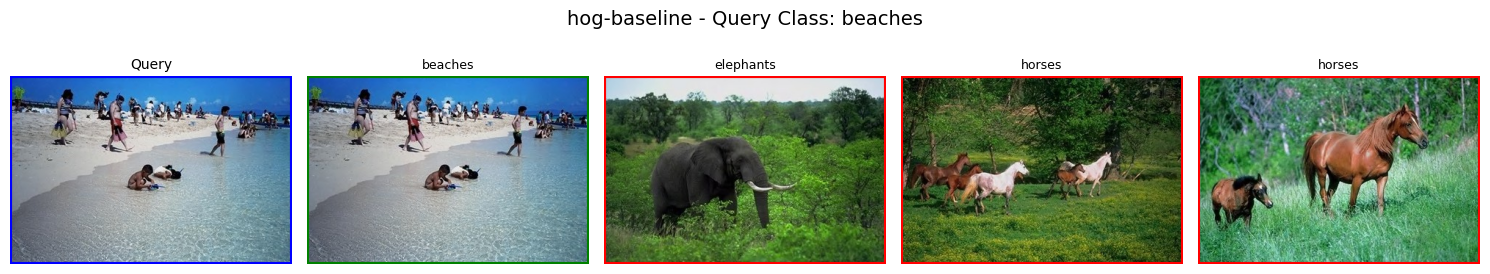


Menampilkan Top-K untuk glcm-baseline:


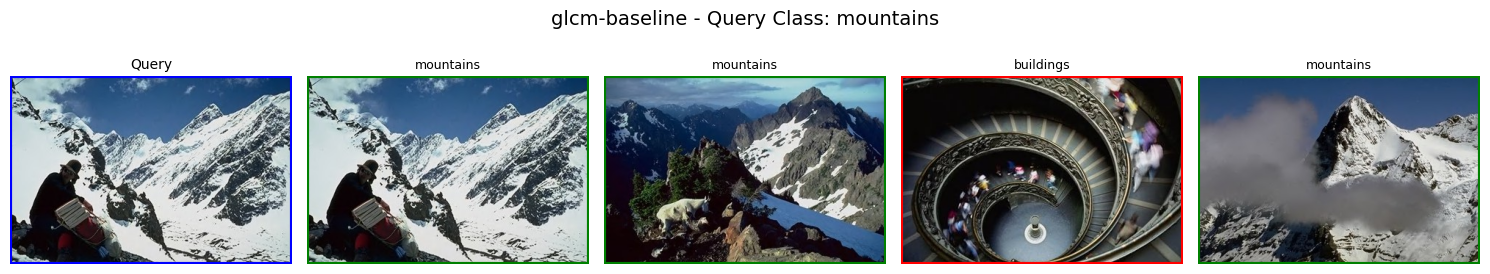


Menampilkan Top-K untuk gist-baseline:


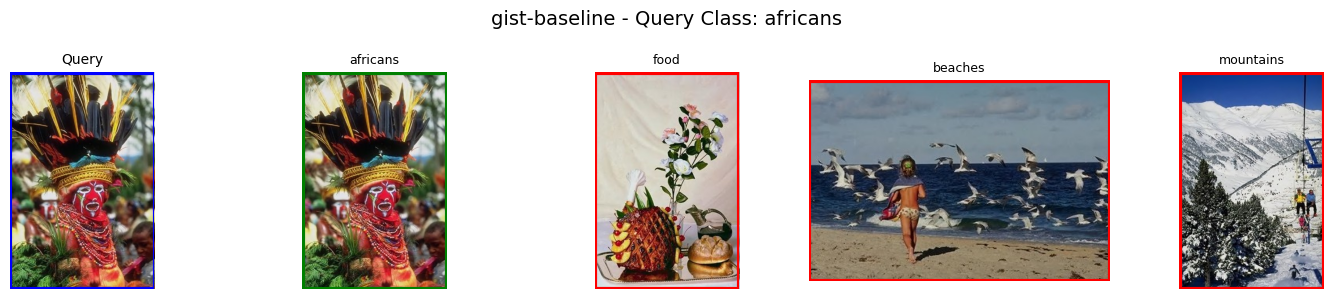

In [7]:
for m_name, feats in features_dict.items():
    model_label = f"{m_name}-baseline"
    print(f"\nMenampilkan Top-K untuk {model_label}:")
    query_idx = random.randint(0, len(labels) - 1)

    show_topk_cbir(
        features=feats,
        labels=labels,
        img_paths=img_paths,
        top_k=4,
        model_name=model_label,
        query_idx=query_idx
    )

### Tahap 4: Model Evaluation

In [8]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from PIL import Image

# =========================
# Fungsi konversi
# =========================
def to_numpy(x):
    return np.array(x, dtype=np.float32)

# =========================
# Measure inference speed classical
# =========================
def measure_inference_speed_batch_classical(model_name, img_paths, batch_size=32):
    if batch_size is None:
        batch_size = len(img_paths)
    times = []

    for i in tqdm(range(0, len(img_paths), batch_size), desc=f"Processing {model_name} batches"):
        batch_imgs = [np.array(Image.open(p).convert("RGB")) for p in img_paths[i:i+batch_size]]
        start = time.time()
        for img in batch_imgs:
            _ = extract_features(model_name, img)  # menggunakan fungsi classical extractor
        end = time.time()
        times.append((end - start)/len(batch_imgs))

    return np.mean(times)

# =========================
# Measure embedding metrics
# =========================
def measure_embedding_metrics(features, labels):
    features = to_numpy(features)
    start = time.time()
    sims = cosine_similarity(features, features)
    search_time = time.time() - start

    classes = list(set(labels))
    inter_dists, intra_dists = [], []

    for i, cls_i in enumerate(classes):
        idx_i = [k for k, l in enumerate(labels) if l == cls_i]
        for j, cls_j in enumerate(classes):
            if i >= j:
                continue
            idx_j = [k for k, l in enumerate(labels) if l == cls_j]
            inter_dists.append(np.mean(sims[np.ix_(idx_i, idx_j)]))

    for cls in classes:
        idx = [k for k, l in enumerate(labels) if l == cls]
        intra_dists.append(np.mean(sims[np.ix_(idx, idx)]))

    return search_time, np.mean(inter_dists), np.mean(intra_dists)

# =========================
# Hitung metrics semua model classical baseline
# =========================
results = []

for m_name in features_dict.keys():  # gunakan keys dari features_dict
    print(f"Processing {m_name}-baseline ...")
    feats = features_dict[m_name]

    # 1. inference speed batch
    avg_inf_time = measure_inference_speed_batch_classical(m_name, img_paths, batch_size=32)

    # 2. embedding metrics
    search_time, inter, intra = measure_embedding_metrics(feats, labels)

    results.append({
        "Model": f"{m_name}-baseline",
        "Inference speed (s/img)": avg_inf_time,
        "Embedding search time (s)": search_time,
        "Inter-class dist": inter,
        "Intra-class dist": intra
    })

df_metrics = pd.DataFrame(results)
display(df_metrics)

Processing hog-baseline ...


Processing hog batches: 100%|██████████| 32/32 [00:35<00:00,  1.10s/it]


Processing glcm-baseline ...


Processing glcm batches: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Processing gist-baseline ...


Processing gist batches: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


,Model,Inference speed (s/img),Embedding search time (s),Inter-class dist,Intra-class dist
0,hog-baseline,0.008224,0.023658,0.749133,0.781860
1,glcm-baseline,0.003961,0.003293,0.979891,0.987663
2,gist-baseline,0.006357,0.003166,0.880657,0.919488


In [9]:
import pandas as pd

# Buat tabel hasil evaluasi
df_table = pd.DataFrame()
df_table['Class'] = sorted(list(set(labels)))

# Tambahkan kolom R & P untuk setiap baseline classical
for m_name, df in eval_results.items():
    # Hanya ada baseline
    col_prefix = f"{m_name}-baseline"
    df_table[f"{col_prefix} R"] = df['R'].astype(float)
    df_table[f"{col_prefix} P"] = df['P'].astype(float)

# Hitung mean per kolom
mean_values = {}
for col in df_table.columns[1:]:
    mean_values[col] = df_table[col].mean()

mean_row = {'Class': 'Mean'}
mean_row.update(mean_values)

# Tambahkan baris Mean
df_table = pd.concat([df_table, pd.DataFrame([mean_row])], ignore_index=True)

# Format angka
for col in df_table.columns[1:]:
    df_table[col] = df_table[col].map("{:.4f}".format)

display(df_table)

,Class,hog-baseline R,hog-baseline P,glcm-baseline R,glcm-baseline P,gist-baseline R,gist-baseline P
0,africans,0.0223,0.2230,0.0402,0.4020,0.0339,0.3390
1,beaches,0.0243,0.2430,0.0379,0.3790,0.0296,0.2960
2,buildings,0.0249,0.2490,0.0409,0.4090,0.0374,0.3740
3,buses,0.0691,0.6910,0.0829,0.8290,0.0549,0.5490
4,dinosaurs,0.0707,0.7070,0.0788,0.7880,0.0395,0.3950
5,elephants,0.0333,0.3330,0.0496,0.4960,0.0367,0.3670
6,flowers,0.0308,0.3080,0.0782,0.7820,0.0559,0.5590
7,food,0.0245,0.2450,0.0521,0.5210,0.0291,0.2910
8,horses,0.0900,0.9000,0.0582,0.5820,0.0268,0.2680
9,mountains,0.0280,0.2800,0.0379,0.3790,0.0299,0.2990


In [10]:
print("Available models:", features_dict.keys())

for model in features_dict:
    print(model, "->", f"{len(features_dict[model])} feature vectors")

Available models: dict_keys(['hog', 'glcm', 'gist'])
hog -> 1000 feature vectors
glcm -> 1000 feature vectors
gist -> 1000 feature vectors


## Dataset: GHIM-10K

### Tahap 1: Model Initialization

In [11]:
# ======================================================
# Tahap 1: Model Initialization (Classical Context Encoders)
# ======================================================
import cv2
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.preprocessing import normalize

# -----------------------------
# Utility preprocessing
# -----------------------------
def preprocess(img, target_size=(128, 128)):
    """
    Resize + CLAHE preprocessing
    """
    img = cv2.resize(np.array(img), target_size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    return gray

# -----------------------------
# Classical feature extractors
# -----------------------------
def extract_hog(img):
    # img sudah grayscale & preprocessed
    return hog(
        img,
        orientations=12,         # lebih banyak orientasi
        pixels_per_cell=(16,16), # lebih besar untuk global info
        cells_per_block=(2,2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )

def extract_glcm(img):
    glcm = graycomatrix(
        img,
        distances=[1,2,3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=32,
        symmetric=True,
        normed=True
    )
    props = ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]
    feat = []
    for p in props:
        feat.extend(graycoprops(glcm, p).flatten())
    return np.array(feat)

def extract_gist(img):
    feats = []
    ksize = 31
    # lebih banyak orientasi
    thetas = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6]
    for theta in thetas:
        kernel = cv2.getGaborKernel((ksize, ksize), sigma=4.0,
                                    theta=theta, lambd=10.0,
                                    gamma=0.5, psi=0)
        fimg = cv2.filter2D(img, cv2.CV_32F, kernel)
        feats.append(fimg.mean())
        feats.append(fimg.var())
    return np.array(feats)

# -----------------------------
# Context & Target Encoders
# -----------------------------
class ContextEncoder:
    def __init__(self, method):
        self.method = method.lower()

    def forward(self, img):
        gray = preprocess(img)
        if self.method == "hog":
            return extract_hog(gray)
        elif self.method == "glcm":
            return extract_glcm(gray)
        elif self.method == "gist":
            return extract_gist(gray)
        else:
            raise ValueError("Unknown method")

class TargetEncoder(ContextEncoder):
    pass

class Predictor:
    def forward(self, z_c):
        return z_c  # identity predictor

# -----------------------------
# Baseline models dictionary
# -----------------------------
context_encoders = {
    "hog": ContextEncoder("hog"),
    "glcm": ContextEncoder("glcm"),
    "gist": ContextEncoder("gist"),
}

### Tahap 2: Feature Extraction (JOINT-EMBEDDING MODELS INITIALIZATION)

In [12]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
from sklearn.preprocessing import normalize
import cv2
from skimage.feature import hog, graycomatrix, graycoprops

# UTILITY / PREPROCESSING
def preprocess(img, target_size=(128,128)):
    """
    Resize + CLAHE grayscale
    """
    img = cv2.resize(np.array(img), target_size)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    return gray

# CLASSICAL FEATURE EXTRACTORS
def extract_hog(img):
    # img sudah grayscale
    return hog(
        img,
        orientations=12,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )

def extract_glcm(img, levels=32):
    # img = grayscale
    # quantize ke 0..levels-1
    img_q = np.floor(img / (256 / levels)).astype(np.uint8)
    glcm = graycomatrix(
        img_q,
        distances=[1,2,3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=levels,
        symmetric=True,
        normed=True
    )
    props = ["contrast","dissimilarity","homogeneity","energy","correlation","ASM"]
    feat = []
    for p in props:
        feat.extend(graycoprops(glcm, p).flatten())
    return np.array(feat)


# FEATURE DISPATCHER
feature_extractors = {
    "hog": extract_hog,
    "glcm": extract_glcm,
    "gist": extract_gist
}

def extract_features(model_name, img):
    gray = preprocess(img)
    return feature_extractors[model_name](gray)


# LOAD DATASET PATHS
img_paths = []
labels = []

for cls in os.listdir(data_dir_GHIM):
    cls_path = os.path.join(data_dir_GHIM, cls)
    for f in os.listdir(cls_path):
        img_paths.append(os.path.join(cls_path, f))
        labels.append(cls)

# MODEL DICTIONARY & FEATURE STORAGE
model_names = ["hog", "glcm", "gist"]
features_dict = {m: [] for m in model_names}

# FEATURE EXTRACTION LOOP
for path in tqdm(img_paths, desc="Extracting Classical Features"):
    img = Image.open(path).convert("RGB")
    for m_name in model_names:
        feat = extract_features(m_name, img)
        features_dict[m_name].append(feat)

# L2 Normalization
for m_name in features_dict: 
    arr = np.array(features_dict[m_name], dtype=np.float32)
    features_dict[m_name] = normalize(arr).tolist()


hog_features   = np.array(features_dict["hog"])
glcm_features  = np.array(features_dict["glcm"])
gist_features  = np.array(features_dict["gist"])

Extracting Classical Features: 100%|██████████| 10016/10016 [10:25<00:00, 16.00it/s]


### Tahap 3: Image Retrieval & Similarity Matching

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# FUNGSI RETRIEVAL
def retrieve(query_feat: np.ndarray, all_feats: np.ndarray, top_k=10):
    sims = cosine_similarity(query_feat[None, :], all_feats)[0]
    idxs = np.argsort(sims)[::-1][:top_k]
    return idxs

# EVALUASI Recall@K dan Precision@K
def evaluate_recall_precision(features, labels, top_k=10, model_type='baseline'):
    features = np.asarray(features, dtype=float)
    classes = sorted(list(set(labels)))
    results = []

    for cls in classes:
        class_idx = [i for i, l in enumerate(labels) if l == cls]
        R_list, P_list = [], []

        for q in class_idx:
            retrieved_idx = retrieve(features[q], features, top_k)
            retrieved_labels = [labels[i] for i in retrieved_idx]

            R = retrieved_labels.count(cls) / len(class_idx)
            P = retrieved_labels.count(cls) / top_k

            R_list.append(R)
            P_list.append(P)

        results.append([cls, np.mean(R_list), np.mean(P_list)])

    df = pd.DataFrame(results, columns=['Class', 'R', 'P'])

    mean_row = {'Class': 'Mean', 'R': df['R'].mean(), 'P': df['P'].mean()}
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)

    df['R'] = df['R'].astype(float).map("{:.4f}".format)
    df['P'] = df['P'].astype(float).map("{:.4f}".format)

    print(f"{model_type} Recall@{top_k} Precision@{top_k} selesai")
    return df

# EVALUASI UNTUK SEMUA MODEL CLASSICAL BASELINE
eval_results = {}

for m_name, feats in features_dict.items():
    df = evaluate_recall_precision(
        feats,
        labels,
        top_k=10,
        model_type=f"{m_name}-baseline"
    )
    eval_results[m_name] = df

hog-baseline Recall@10 Precision@10 selesai
glcm-baseline Recall@10 Precision@10 selesai
gist-baseline Recall@10 Precision@10 selesai


In [14]:
def to_numpy(features):
    # Jika features berupa list
    if isinstance(features, list):
        # Jika list berisi tuple (embedding, path)
        if len(features) > 0 and isinstance(features[0], tuple):
            return np.array([f[0] for f in features], dtype=np.float32)
        else:
            return np.array(features, dtype=np.float32)
    return features

In [15]:
def show_topk_cbir(features, labels, img_paths, top_k=4, model_name="Model", query_idx=None):
    # Pastikan features berupa numpy array
    features = to_numpy(features)

    # Pilih query secara acak jika tidak diberikan
    if query_idx is None:
        query_idx = random.randint(0, len(labels) - 1)

    query_class = labels[query_idx]
    retrieved_idx = retrieve(features[query_idx], features, top_k)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{model_name} - Query Class: {query_class}", fontsize=14)

    # Tampilkan gambar query
    query_img = Image.open(img_paths[query_idx]).convert('RGB')
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query", fontsize=10)
    plt.gca().add_patch(patches.Rectangle(
        (0, 0), query_img.width, query_img.height,
        edgecolor='blue', fill=False, linewidth=3
    ))

    # Tampilkan top-k hasil retrieval
    for i, idx in enumerate(retrieved_idx):
        img = Image.open(img_paths[idx]).convert('RGB')
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')

        # Warna kotak: hijau jika benar, merah jika salah
        color = 'green' if labels[idx] == query_class else 'red'
        plt.gca().add_patch(patches.Rectangle(
            (0, 0), img.width, img.height,
            edgecolor=color, fill=False, linewidth=3
        ))
        plt.title(labels[idx], fontsize=9)

    plt.tight_layout()
    plt.show()


Menampilkan Top-K untuk hog-baseline:


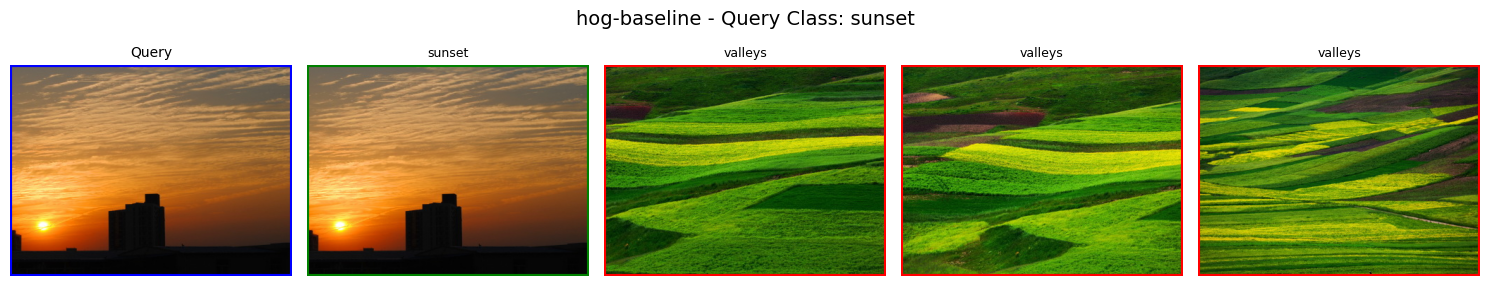


Menampilkan Top-K untuk glcm-baseline:


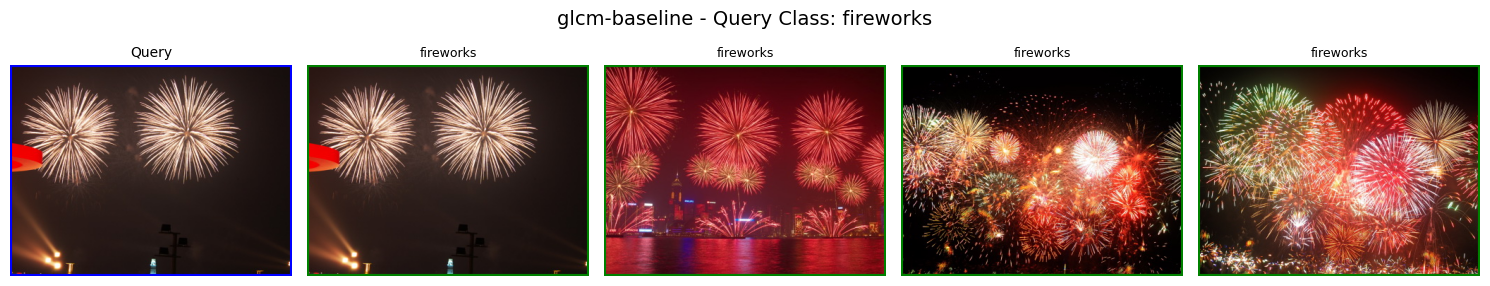


Menampilkan Top-K untuk gist-baseline:


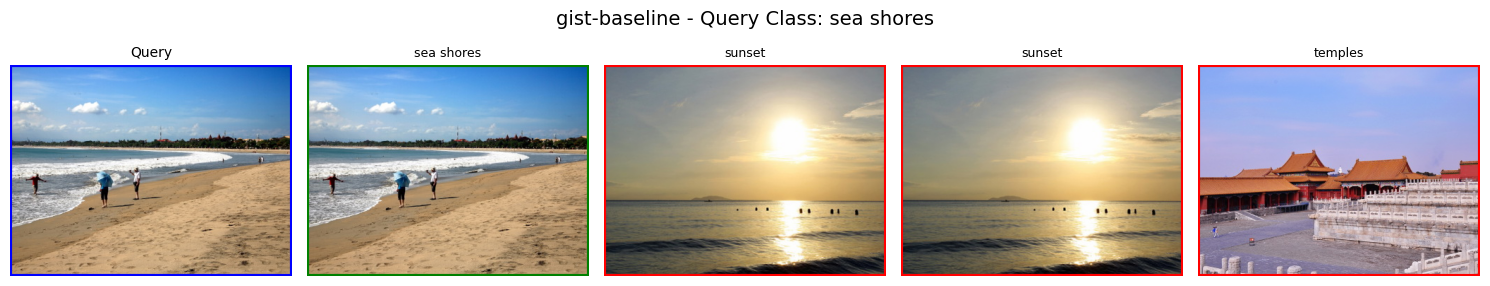

In [16]:
for m_name, feats in features_dict.items():
    model_label = f"{m_name}-baseline"
    print(f"\nMenampilkan Top-K untuk {model_label}:")
    query_idx = random.randint(0, len(labels) - 1)

    show_topk_cbir(
        features=feats,
        labels=labels,
        img_paths=img_paths,
        top_k=4,
        model_name=model_label,
        query_idx=query_idx
    )

### Tahap 4: Model Evaluation

In [17]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from PIL import Image

# =========================
# Fungsi konversi
# =========================
def to_numpy(x):
    return np.array(x, dtype=np.float32)

# =========================
# Measure inference speed classical
# =========================
def measure_inference_speed_batch_classical(model_name, img_paths, batch_size=32):
    if batch_size is None:
        batch_size = len(img_paths)
    times = []

    for i in tqdm(range(0, len(img_paths), batch_size), desc=f"Processing {model_name} batches"):
        batch_imgs = [np.array(Image.open(p).convert("RGB")) for p in img_paths[i:i+batch_size]]
        start = time.time()
        for img in batch_imgs:
            _ = extract_features(model_name, img)  # menggunakan fungsi classical extractor
        end = time.time()
        times.append((end - start)/len(batch_imgs))

    return np.mean(times)

# =========================
# Measure embedding metrics
# =========================
def measure_embedding_metrics(features, labels):
    features = to_numpy(features)
    start = time.time()
    sims = cosine_similarity(features, features)
    search_time = time.time() - start

    classes = list(set(labels))
    inter_dists, intra_dists = [], []

    for i, cls_i in enumerate(classes):
        idx_i = [k for k, l in enumerate(labels) if l == cls_i]
        for j, cls_j in enumerate(classes):
            if i >= j:
                continue
            idx_j = [k for k, l in enumerate(labels) if l == cls_j]
            inter_dists.append(np.mean(sims[np.ix_(idx_i, idx_j)]))

    for cls in classes:
        idx = [k for k, l in enumerate(labels) if l == cls]
        intra_dists.append(np.mean(sims[np.ix_(idx, idx)]))

    return search_time, np.mean(inter_dists), np.mean(intra_dists)

# =========================
# Hitung metrics semua model classical baseline
# =========================
results = []

for m_name in features_dict.keys():  # gunakan keys dari features_dict
    print(f"Processing {m_name}-baseline ...")
    feats = features_dict[m_name]

    # 1. inference speed batch
    avg_inf_time = measure_inference_speed_batch_classical(m_name, img_paths, batch_size=32)

    # 2. embedding metrics
    search_time, inter, intra = measure_embedding_metrics(feats, labels)

    results.append({
        "Model": f"{m_name}-baseline",
        "Inference speed (s/img)": avg_inf_time,
        "Embedding search time (s)": search_time,
        "Inter-class dist": inter,
        "Intra-class dist": intra
    })

df_metrics = pd.DataFrame(results)
display(df_metrics)

Processing hog-baseline ...


Processing hog batches: 100%|██████████| 313/313 [02:28<00:00,  2.10it/s]


Processing glcm-baseline ...


Processing glcm batches: 100%|██████████| 313/313 [00:52<00:00,  5.99it/s]


Processing gist-baseline ...


Processing gist batches: 100%|██████████| 313/313 [01:00<00:00,  5.13it/s]


,Model,Inference speed (s/img),Embedding search time (s),Inter-class dist,Intra-class dist
0,hog-baseline,0.004616,1.199276,0.727838,0.757308
1,glcm-baseline,0.002963,0.913863,0.971509,0.984352
2,gist-baseline,0.003849,0.526050,0.862485,0.914639


In [18]:
import pandas as pd

# Buat tabel hasil evaluasi
df_table = pd.DataFrame()
df_table['Class'] = sorted(list(set(labels)))

# Tambahkan kolom R & P untuk setiap baseline classical
for m_name, df in eval_results.items():
    # Hanya ada baseline
    col_prefix = f"{m_name}-baseline"
    df_table[f"{col_prefix} R"] = df['R'].astype(float)
    df_table[f"{col_prefix} P"] = df['P'].astype(float)

# Hitung mean per kolom
mean_values = {}
for col in df_table.columns[1:]:
    mean_values[col] = df_table[col].mean()

mean_row = {'Class': 'Mean'}
mean_row.update(mean_values)

# Tambahkan baris Mean
df_table = pd.concat([df_table, pd.DataFrame([mean_row])], ignore_index=True)

# Format angka
for col in df_table.columns[1:]:
    df_table[col] = df_table[col].map("{:.4f}".format)

display(df_table)

,Class,hog-baseline R,hog-baseline P,glcm-baseline R,glcm-baseline P,gist-baseline R,gist-baseline P
0,aircraft,0.0042,0.2102,0.0066,0.3296,0.0038,0.1880
1,buildings,0.0065,0.3260,0.0103,0.5126,0.0053,0.2658
2,butterfly,0.0025,0.1250,0.0064,0.3214,0.0044,0.2220
3,cars,0.0084,0.4200,0.0082,0.4104,0.0044,0.2204
4,dragon fly,0.0031,0.1550,0.0072,0.3584,0.0048,0.2414
5,fireworks,0.0137,0.6848,0.0110,0.5482,0.0049,0.2464
6,flowers,0.0032,0.1586,0.0104,0.5208,0.0054,0.2710
7,hen,0.0083,0.4166,0.0051,0.2542,0.0036,0.1778
8,horses,0.0059,0.2942,0.0070,0.3486,0.0045,0.2254
9,insects,0.0032,0.1612,0.0059,0.2932,0.0046,0.2296


In [19]:
print("Available models:", features_dict.keys())

for model in features_dict:
    print(model, "->", f"{len(features_dict[model])} feature vectors")

Available models: dict_keys(['hog', 'glcm', 'gist'])
hog -> 10016 feature vectors
glcm -> 10016 feature vectors
gist -> 10016 feature vectors
